# Negociação de Ativos Financeiros
## Análise Gráfica
## Tendências
### Tendência de Alta
#### Mínimo maior
Em uma tendência de alta, os mínimos maiores são conhecidos como correções de preços, geralmente aparecendo de 3 a 5 vezes.
### Tendência de Baixa
#### Máximo menor
Em uma tendência de baixa, os máximos maiores são conhecidos como correções de preços, geralmente aparecendo de 3 a 5 vezes.
### Tendência Lateral
Os preços oscilam entre um nível de suporte e resitência, a decisão de compra ou venta está de acordo com os níveis de suporte e resistência.
## Padrões Gráficos
Os padrões gráficos ajudam a antecipar uma mudança de tendência.
### Martelo
É encontrado quando um tendência de baixa troca para alta. É possível que o candle associado possua um corpo vermelho ou verde, na qual a sombra é maior que o corpo pelo menos 2x.
### "Ahorcado" (Forca)
É encontrado na transição de uma tendência alta para baixa, possuindo formato semelhante ao do martelo, com a sombra sendo maior que o corpo pelo menos 2x.


## Analíse Técnica
## Médias Móveis
Geralmente são usadas médias móveis simples ou exponenciais.

As médias móveis são geralmente usadas em pares, em que há uma curto e outra de longo prazo.

Quando uma média móvel de curto prazo rompe acima da de longo prazo, então isso é um sinal de  compra. Entende-se que o preço aumentou drasticamente dado os preços anteriores. 
- Representado por um triângulo verde apontado para cima.

Por outro lado, quando a média móvel de curto prazo rompe abaixo da média de longo prazo, então é um sinal de venda.
-  Representado por um triângulo vermelho apontado para baixo.

## Bandas de Bollinger
É utilizada uma média móvel simples para a central e a partir dela geramos a superior e inferior.

Caso o preço rompa a banda inferior, então podemos enteder como um sinal de compra, pois o ativo está possívemente sobrevendido.

Caso contrário, quando o preço rompe a banda superior, então é um sinal de venda, pois o ativo está sobrecomprado.


## Osciladores
Buscam entender possíveis sobrecompras ou sobrevendas em curto prazo.

### MACD(12, 26) - Moving Average of Convergence and Divergence
Qaando o oscilador é positivo, então entendemos que há uma possível sobrecompra, gerando um gatilho para um sinal de venda.

Quando é negativo, então está sobrevendido e é um sinal de compra.

## Níveis de Suporte e Resistência
Podemos entender os níveis de suporte e resistência como pontos onde a tendência será revertida. No caso do preço romper o nível de suporte ou de resistência, então é gerado um sinal de compra ou venda.

Caso rompa acima é um sinal de compra, caso rompa abaixo é venda.

In [1]:
# pip install pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import yfinance as yfin
import matplotlib.pyplot as plt
import mplfinance as mpf
import ta
import pandas_datareader as pdr

In [269]:
def graficoEstrategia(df, shortMM, longMM):
    plt.figure(figsize = (20, 10))
    plt.plot(df['Close'], alpha = 0.6, label = 'Preços')

    plt.scatter(df.index, df['Compra'], color = 'green', marker = '^', label = 'Compra')
    plt.scatter(df.index, df['Venda'], color = 'crimson', marker = 'v', label = 'Venda')

    plt.title(f'Sinais de Compra e Venda, EMA {shortMM} & EMA {longMM}')
    plt.xlabel('Dia')
    plt.ylabel('Preço USD/bbl')
    plt.legend(loc = 'upper left')

    return plt


def graficoPatrimonio(ativo):
    plt.figure(figsize = (20, 10))
    plt.plot(ativo['Equity'])
    plt.title('Patrimônio - Estratégia de Médias Móveis Exponencias')
    plt.xlabel('Dia')
    plt.ylabel('Valor')
    plt.show()

def calculaParametros(df, risk_free):
    retornos = np.log(df['Equity']).diff().mean()
    retornos = retornos * 252
    #print(retornos)
    volatility = np.log(df['Equity']).diff().std()
    volatility = volatility * np.sqrt(252)
    #print(volatility)
    sharpe_ratio = (retornos - risk_free)/volatility
    
    return retornos, volatility, sharpe_ratio   
    
def estrategiaMediaMovel(ativo, inicio, fim, intervalo, shortMM, longMM):
    def algoritmo(dfTemp):
        n = len(dfTemp)       
        sinais = [0]

        for i in range(1, n):
            short = dfTemp['EMA_short'][i]
            long = dfTemp['EMA_long'][i]

            previous_short = dfTemp['EMA_short'][i-1]
            previous_long = dfTemp['EMA_long'][i-1]

            if previous_short < previous_long and short >= long:
                sinais.append(1)

            elif previous_short > previous_long and short <= long:
                sinais.append(-1)

            else:
                sinais.append(0)

        dfTemp['Sinais'] = sinais
        dfTemp['Compra'] = np.where(dfTemp['Sinais'] == 1, dfTemp['Close'], np.nan)
        dfTemp['Venda'] = np.where(dfTemp['Sinais'] == -1, dfTemp['Close'], np.nan)
        
        return dfTemp
        


    df = yfin.download(ativo, inicio, fim, interval = intervalo)
    df = df.dropna()
    df['EMA_short'] = df['Close'].ewm(span =shortMM, adjust = False).mean()
    df['EMA_long'] = df['Close'].ewm(span = longMM, adjust = False).mean()
    
    df = algoritmo(df)
    #resultado = grafico(df, shortMM, longMM)
    
    return df#, grafico
    
def backtestEstrategia(ativo, equity, TP, SL):
    '''Backtesting: Retorna o DataFrame com a variação de patrimônio, retorno, volatilidade e sharpe ratio da estratégia'''   
    
    N = len(ativo)
    equity = [equity]

    # Take Profit (lucro/stop gain) TP
    # Stop Loss SL

    pos = 0

    for i in range(1, N):

        equity.append(equity[i-1])

        if pos == 1:
            if ativo['Close'][i] >= preco*(1 + TP):
                pos = 0
                equity[i] *= (1 + TP)

            elif ativo['Close'][i] <= preco*(1 - SL):
                pos = 0
                equity[i] *= (1 - SL)


        elif pos == -1:
            if ativo['Close'][i] <= preco*(1 - TP):
                pos = 0
                equity[i] *= (1 + TP)

            elif ativo['Close'][i] >= preco*(1 + SL):
                pos = 0
                equity[i] *= (1 - SL)


        else:
            if ativo['Sinais'][i] != 0:
                pos = ativo['Sinais'][i]
                preco = ativo['Close'][i]
        #print(equity)   

    ativo['Equity'] = equity
    
    

    return ativo
    

In [281]:
ativo = estrategiaMediaMovel('ITUB4.SA', '2022-01-01','2023-01-01', '1d', 3, 13)
ativo = backtestEstrategia(ativo, 100, 0.03, 0.01) # ESTRATEGIA
retornos, volatilidade, indiceSharpe = calculaParametros(ativo, 0.1275) # Parâmetros de Risco
print(f"Retornos {round(retornos, 2)}, Volatilidade {round(volatilidade, 2)}, Sharpe Ratio {round(indiceSharpe, 2)}")

[*********************100%***********************]  1 of 1 completed
Retornos 0.2, Volatilidade 0.09, Sharpe Ratio 0.83


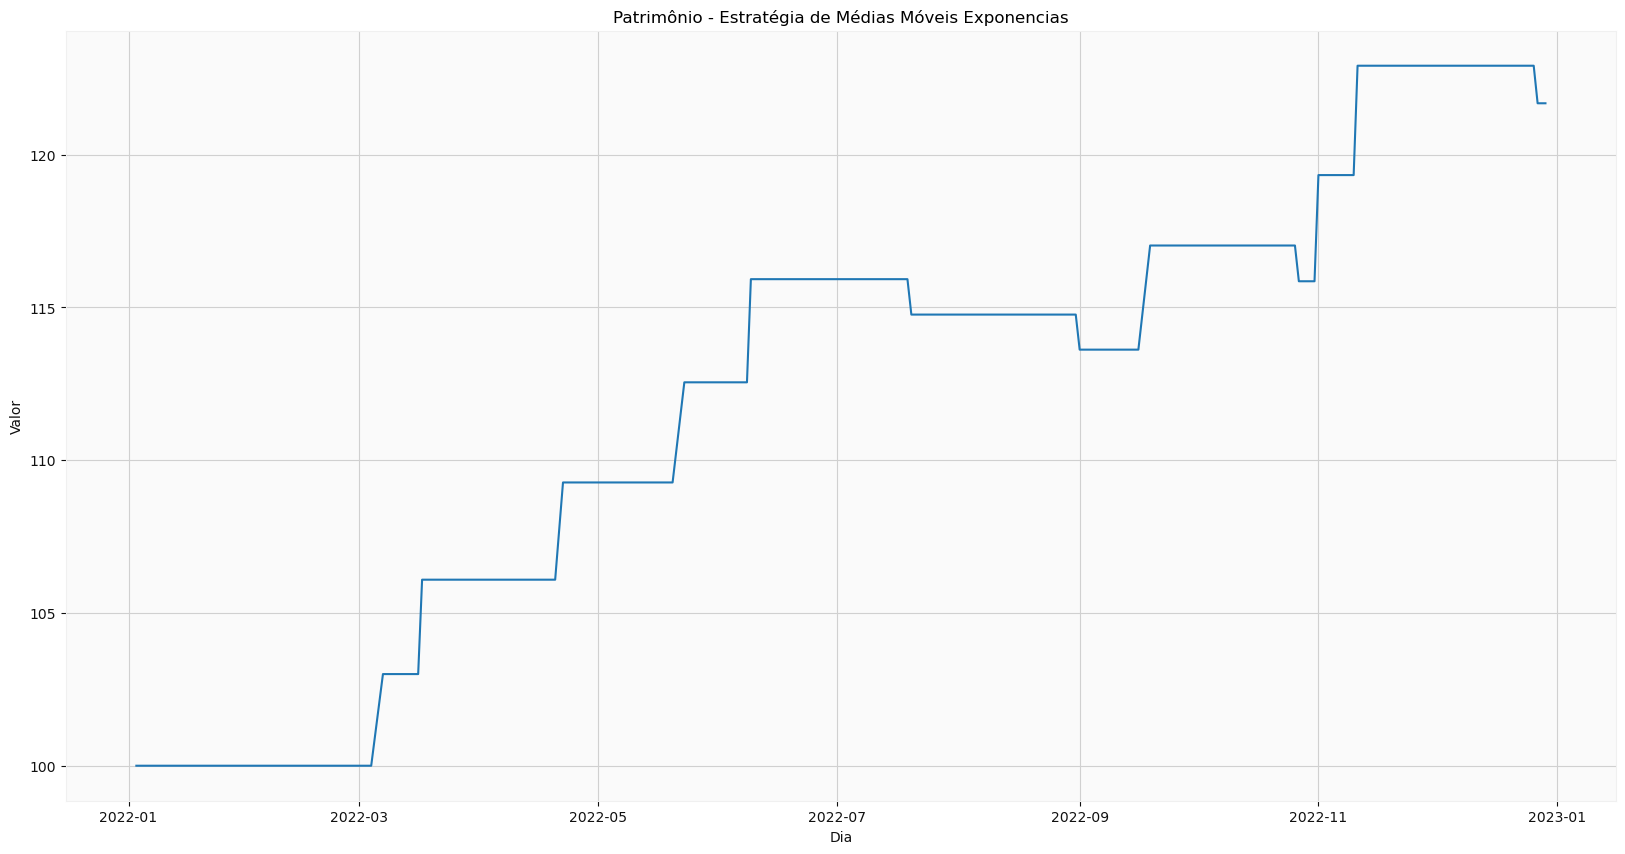

In [282]:
graficoPatrimonio(ativo)

# Exemplos nas Aulas

[*********************100%***********************]  1 of 1 completed


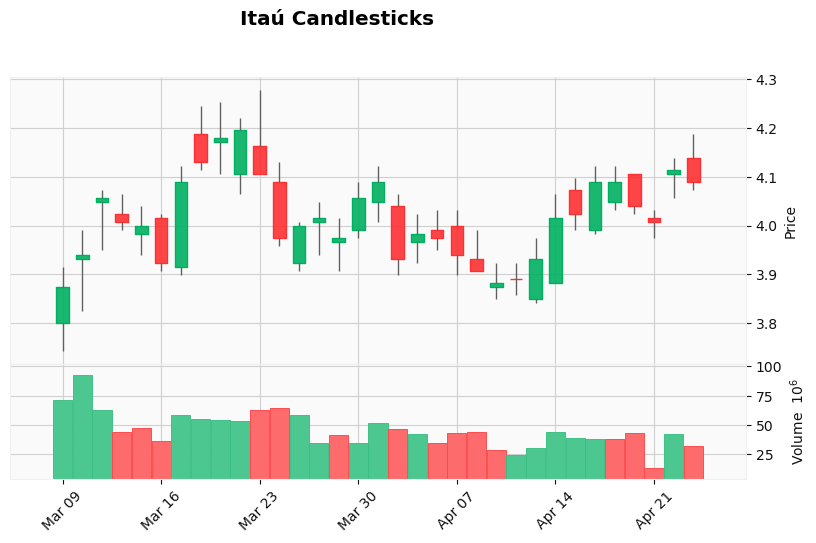

In [3]:
# Atividade
dfITCB = yfin.download('ITUB', '2021-03-09', '2021-04-25')
mpf.plot(
    dfITCB,
    type = 'candle',
    volume = True,
    figratio = (16, 9),
    style = 'yahoo',
    title = 'Itaú Candlesticks'
)

In [39]:
# Sinais de Trading
dfPetro = pdr.get_data_fred('DCOILBRENTEU', '2016-01-01', '2021-01-01')
dfPetro = dfPetro.dropna()
dfPetro.columns = ['Close']


In [40]:
# Aplicando a estratégia das médias móveis exponenciais
dfPetro['EMA_short'] = dfPetro['Close'].ewm(span = 5, adjust = False).mean()
dfPetro['EMA_long'] = dfPetro['Close'].ewm(span = 20, adjust = False).mean()


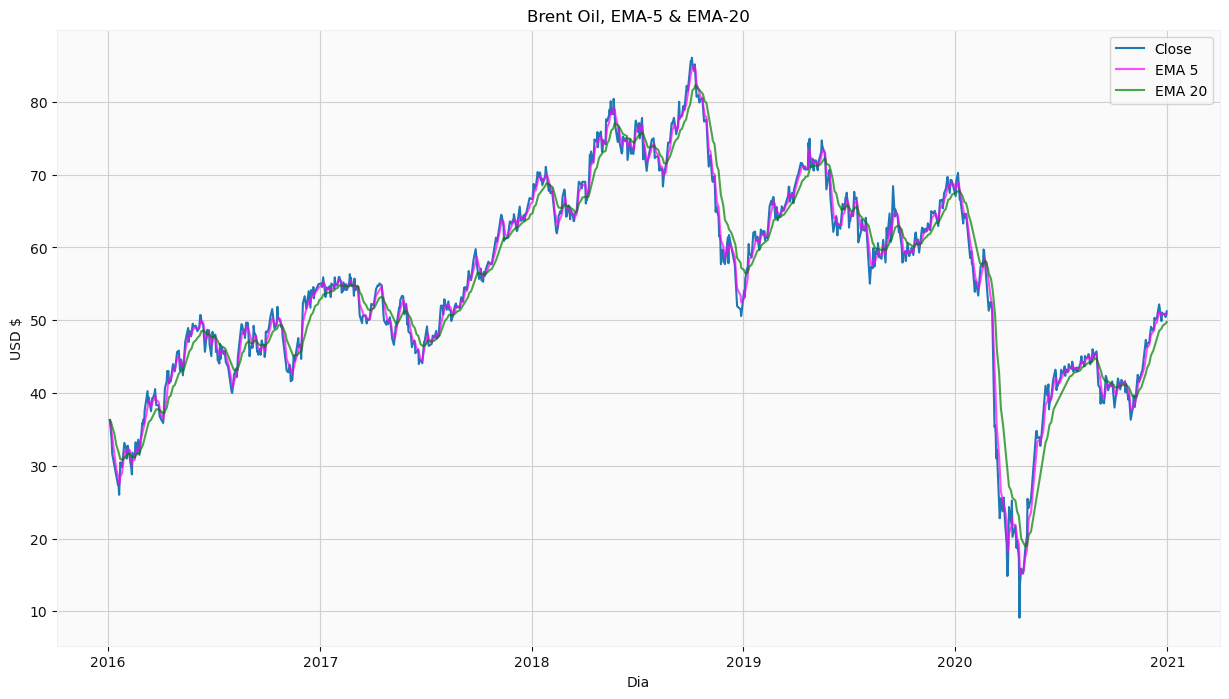

In [41]:
plt.figure(figsize = (15, 8))
plt.title('Brent Oil, EMA-5 & EMA-20')
plt.plot(dfPetro['Close'])
plt.plot(dfPetro['EMA_short'], color = 'magenta', alpha = 0.7)
plt.plot(dfPetro['EMA_long'], color = 'green', alpha = 0.7)
plt.xlabel('Dia')
plt.ylabel('USD $')
plt.legend(['Close', 'EMA 5', 'EMA 20'])
plt.show()

In [106]:
# Primeiro algoritmo :)

# Número de dados
n = len(dfPetro)
# Lista de sinais
# -1 Vender
# 0 manter
# 1 Comprar
sinais = [0]

for i in range(1, n):
    short = dfPetro['EMA_short'][i]
    long = dfPetro['EMA_long'][i]
    
    previous_short = dfPetro['EMA_short'][i-1]
    previous_long = dfPetro['EMA_long'][i-1]
    
    if previous_short < previous_long and short >= long:
        sinais.append(1)
        
    elif previous_short > previous_long and short <= long:
        sinais.append(-1)
    
    else:
        sinais.append(0)

dfPetro['Sinais'] = sinais
    

In [107]:
dfPetro['Compra'] = np.where(dfPetro['Sinais'] == 1, dfPetro['Close'], np.nan)
dfPetro['Venda'] = np.where(dfPetro['Sinais'] == -1, dfPetro['Close'], np.nan)
#dfPetro

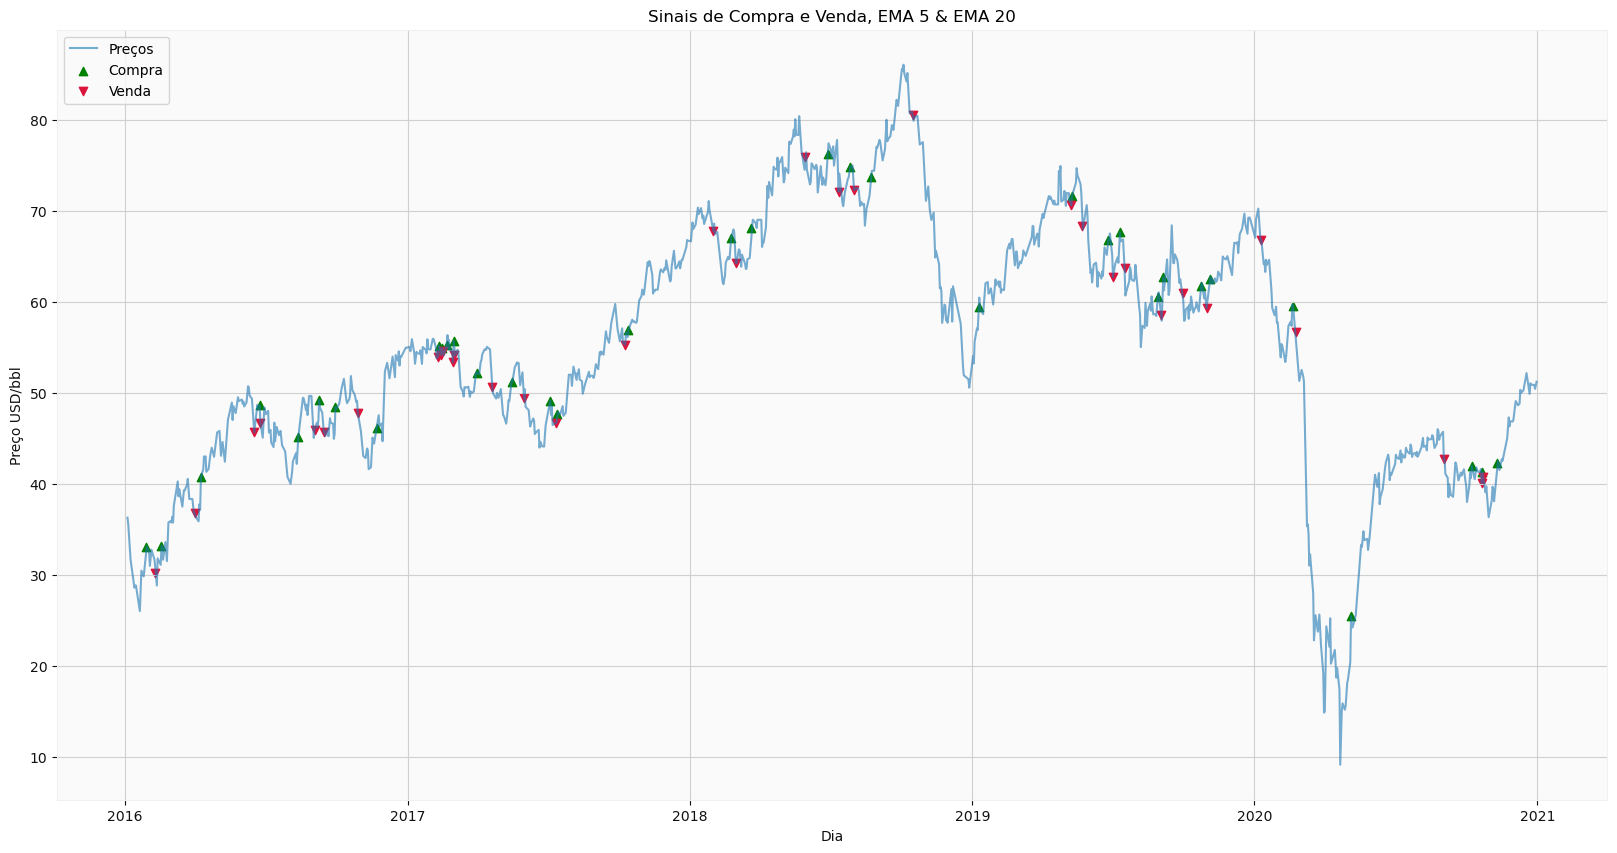

In [108]:
plt.figure(figsize = (20, 10))
plt.plot(dfPetro['Close'], alpha = 0.6, label = 'Preços')

plt.scatter(dfPetro.index, dfPetro['Compra'], color = 'green', marker = '^', label = 'Compra')
plt.scatter(dfPetro.index, dfPetro['Venda'], color = 'crimson', marker = 'v', label = 'Venda')

plt.title('Sinais de Compra e Venda, EMA 5 & EMA 20')
plt.xlabel('Dia')
plt.ylabel('Preço USD/bbl')
plt.legend(loc = 'upper left')

plt.show()

In [203]:
# Backtesting
ativo = dfPetro
N = len(ativo)
equity = [100]

TP = 0.03 # Total Profit (lucro/stop gain)
SL = 0.01 # Stop Loss

pos = 0

for i in range(1, N):
    
    equity.append(equity[i-1])
    
    if pos == 1:
        if ativo['Close'][i] >= preco*(1 + TP):
            pos = 0
            equity[i] *= (1 + TP)
            
        elif ativo['Close'][i] <= preco*(1 - SL):
            pos = 0
            equity[i] *= (1 - SL)
            
            
    elif pos == -1:
        if ativo['Close'][i] <= preco*(1 - TP):
            pos = 0
            equity[i] *= (1 + TP)
            
        elif ativo['Close'][i] >= preco*(1 + SL):
            pos = 0
            equity[i] *= (1 - SL)
        
    
    else:
        if ativo['Sinais'][i] != 0:
            pos = ativo['Sinais'][i]
            preco = ativo['Close'][i]
    #print(equity)   
            
ativo['Equity'] = equity

In [143]:
ativo

,Close,EMA_short,EMA_long,Sinais,Compra,Venda,Equity
DATE,,,,,,,
2016-01-04,36.28,36.280000,36.280000,0,NaN,NaN,100.000000
2016-01-05,35.56,36.040000,36.211429,0,NaN,NaN,100.000000
2016-01-06,33.89,35.323333,35.990340,0,NaN,NaN,100.000000
2016-01-07,33.57,34.738889,35.759832,0,NaN,NaN,100.000000
2016-01-08,31.67,33.715926,35.370324,0,NaN,NaN,100.000000
...,...,...,...,...,...,...,...
2020-12-24,50.88,50.792761,49.228966,0,NaN,NaN,122.044183
2020-12-28,50.88,50.821840,49.386208,0,NaN,NaN,122.044183
2020-12-29,50.44,50.694560,49.486569,0,NaN,NaN,122.044183


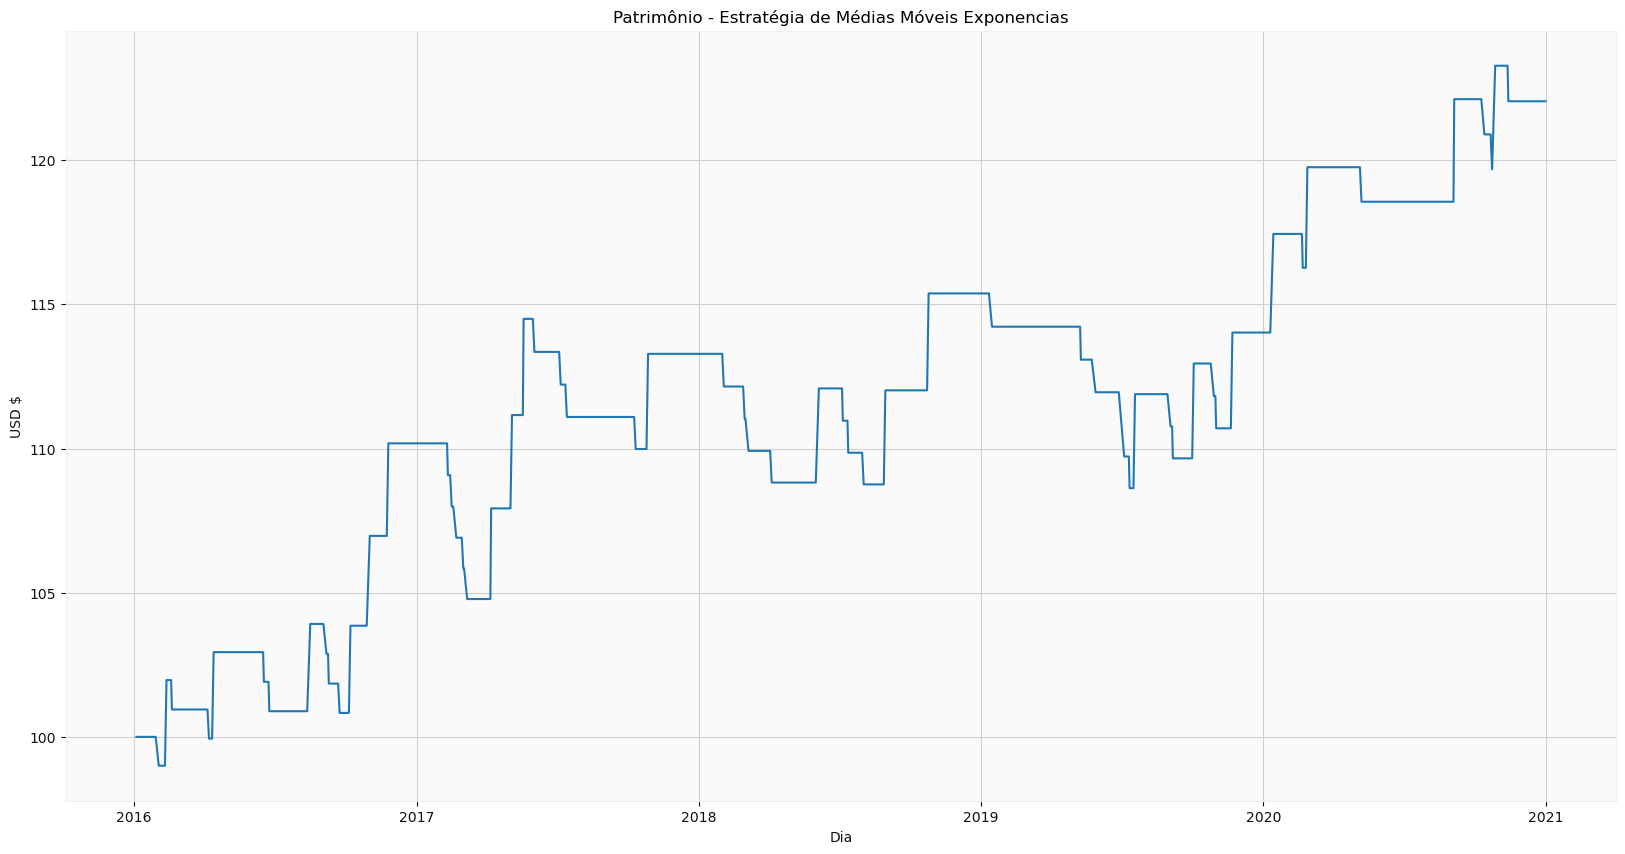

In [163]:
plt.figure(figsize = (20, 10))
plt.plot(ativo['Equity'])
plt.title('Patrimônio - Estratégia de Médias Móveis Exponencias')
plt.xlabel('Dia')
plt.ylabel('USD $')
plt.show()

In [204]:
ret = np.log(ativo['Equity']).diff().mean()
ret = ret * 252

vol = np.log(ativo['Equity']).diff().std()
vol = vol * np.sqrt(252)

rf = 0.01 # Taxa livre de risco

sharpe_ratio = (ret - rf)/vol
sharpe_ratio

0.4519606496376948

In [211]:
# Comparando com o S&P500
# Precisamos pensar quantos portfólios poderiamos comprar com o equity q temos
sp = estrategiaMediaMovel('^GSPC', '2016-01-01','2021-01-01', '1d', 5, 20)
sp= backtestEstrategia(sp, 100, 0.03, 0.01)
sp['Equity'] = (100/sp['Close'][0]) * sp['Close']

[*********************100%***********************]  1 of 1 completed


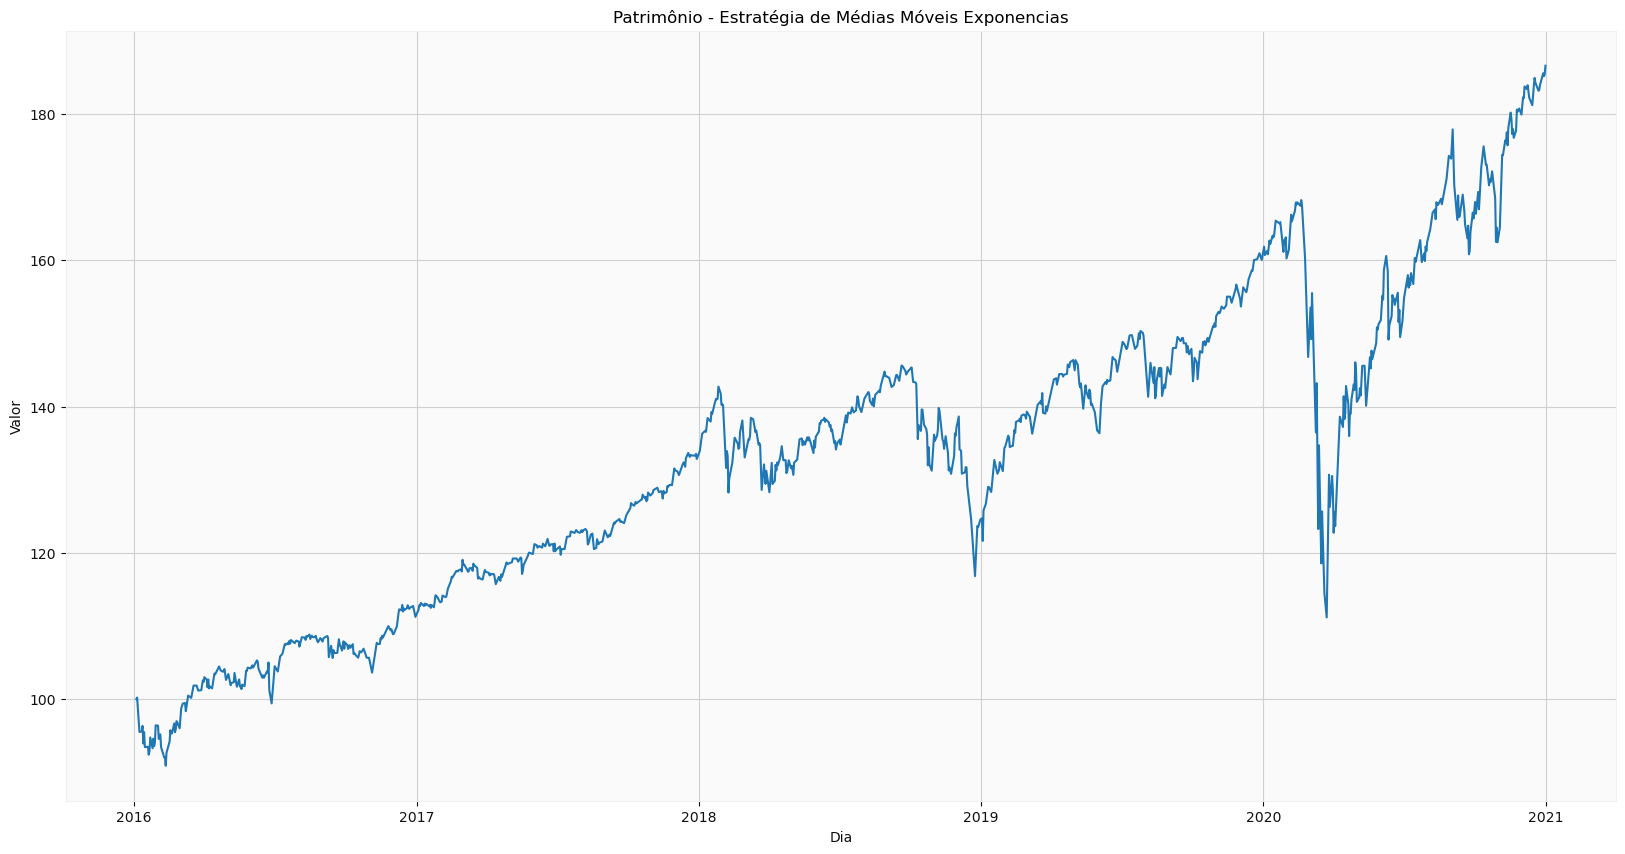

In [206]:
graficoPatrimonio(sp)

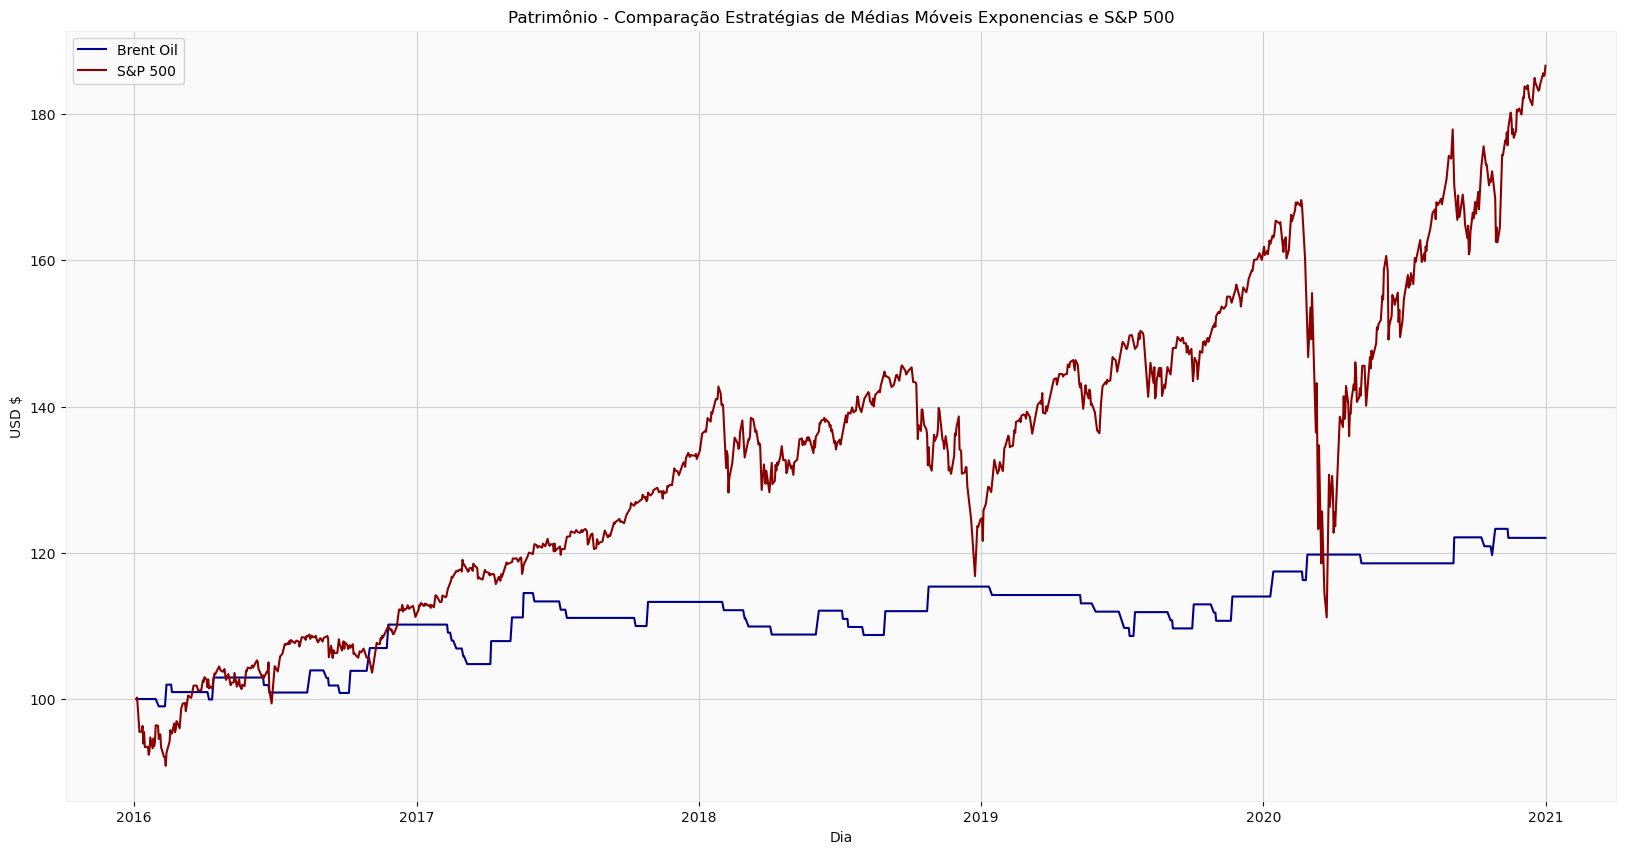

In [207]:
plt.figure(figsize = (20, 10))
plt.plot(ativo['Equity'], color = 'darkblue')
plt.plot(sp['Equity'], color = 'darkred')
plt.title('Patrimônio - Comparação Estratégias de Médias Móveis Exponencias e S&P 500')
plt.xlabel('Dia')
plt.ylabel('USD $')
plt.legend(['Brent Oil', 'S&P 500'])
plt.show()

In [222]:
sp_retorno, sp_volatilidade, sp_sharpe = calculaParametros(sp, 0.01)
sp_sharpe

0.5948105492214403

In [237]:
ativo = estrategiaMediaMovel('AMZN', '2020-01-01','2021-01-01', '1d', 5, 20)
ativo = backtestEstrategia(ativo, 100, 0.03, 0.01)
retornos, volatilidade, indiceSharpe = calculaParametros(ativo, 0.01)

[*********************100%***********************]  1 of 1 completed


In [244]:
ativo[ativo['Sinais'] != 0]

,Open,High,Low,Close,Adj Close,Volume,EMA_short,EMA_long,Sinais,Compra,Venda,Equity
Date,,,,,,,,,,,,
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,94.931443,94.873811,1,95.343002,NaN,100.000000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,94.820463,94.847591,-1,NaN,94.598503,100.000000
2020-01-09,95.494499,95.890999,94.790001,95.052498,95.052498,63346000,94.897808,94.867106,1,95.052498,NaN,100.000000
2020-01-10,95.268501,95.347000,94.000000,94.157997,94.157997,57074000,94.651204,94.799572,-1,NaN,94.157997,99.000000
2020-01-31,102.573502,102.786003,100.113503,100.435997,100.435997,311346000,95.549284,94.364920,1,100.435997,NaN,99.000000
2020-02-26,98.514000,100.733498,98.022499,98.979500,98.979500,104492000,101.387107,102.225620,-1,NaN,98.979500,101.970000
2020-03-24,97.574997,97.750000,95.016998,97.004997,97.004997,142942000,94.162424,94.046842,1,97.004997,NaN,105.029100
2020-09-09,160.149506,165.158997,159.250000,163.430496,163.430496,103774000,164.750311,164.980394,-1,NaN,163.430496,103.978809
2020-10-01,160.399994,161.199997,158.600006,161.063004,161.063004,99438000,157.792101,157.205161,1,161.063004,NaN,107.098173


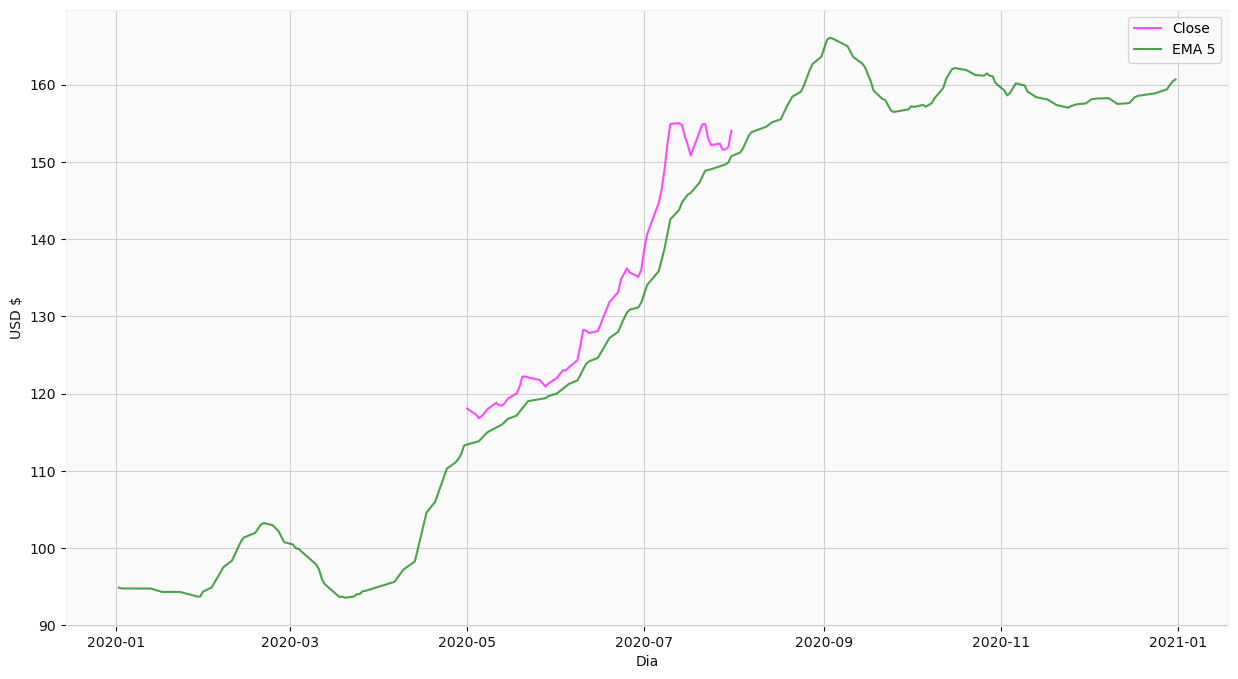

In [243]:
plt.figure(figsize = (15, 8))
plt.plot(ativo['2020-05-1':'2020-08-1']['EMA_short'], color = 'magenta', alpha = 0.7)
plt.plot(ativo['EMA_long'], color = 'green', alpha = 0.7)
plt.xlabel('Dia')
plt.ylabel('USD $')
plt.legend(['Close', 'EMA 5', 'EMA 20'])
plt.show()